In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-


# Deep Neural Networks

## Session 05z - For animation
### Neural Network with :
- One hidden layer 
- ${Tanh}$ activation function
- Compare with Tensorflow implementation


<img src='../../images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
###-----------------
### Import Libraries
###-----------------

import os
import glob
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.animation as animation

from tqdm import tqdm

from collections.abc import Callable
from typing import Literal

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

%matplotlib inline

In [3]:
###----------------
### Some parameters
###----------------

inpDir = '../input'
outDir = '../output'

RANDOM_STATE = 24 # REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results

EPOCHS = 10001 # number of epochs
ALPHA = 0.1 # learning rate
NUM_SAMPLES = 1280 # How many samples we want to generate 
NOISE = 0.2 # Noise to be introduced in the data
TEST_SIZE = 0.2

# parameters for Matplotlib
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (16,9),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'
         }

CMAP = 'coolwarm' # plt.cm.Spectral

plt.rcParams.update(params)

### Helper Functions

In [4]:
###-----------------------------------
### Function to plot Decision boundary
###-----------------------------------

def fn_plot_decision_boundary(pred_func: Callable[[], np.float64], X: np.ndarray, y: np.ndarray):
    '''
        Attrib:
           pred_func : function based on predict method of the classifier
           X : feature matrix
           y : targets
       Return:
           None
    '''
    
    # Set min and max values and give it some padding
    xMin, xMax = X[:, 0].min() - .05, X[:, 0].max() + .05
    yMin, yMax = X[:, 1].min() - .05, X[:, 1].max() + .05
    
    # grid size for mesh grid
    h = 0.01
    
    # Generate a grid of points with distance 'h' between them
    xx, yy = np.meshgrid(np.arange(xMin, xMax, h), np.arange(yMin, yMax, h))
    
    # Predict the function value for the whole grid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    
    # Make its shape same as that of xx 
    Z = Z.reshape(xx.shape)
    
    # Now we have Z value corresponding to each of the combination of xx and yy
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=CMAP) #, alpha = 0.8
    
    # plot the points as well
    plt.scatter(X[:, 0], X[:, 1], c=np.argmax(y, axis =1), cmap=CMAP, edgecolors='black')

## Generate Data Set
<p style="font-family: Arial; font-size:1.1em;color:blue;">
Use Sklearn's dataset generator <a href="http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html">make_moon</a>.
</p>

In [5]:
X, y = datasets.make_moons(n_samples=NUM_SAMPLES, shuffle=True, noise=NOISE, random_state=RANDOM_STATE)

In [6]:
X.shape, y.shape

((1280, 2), (1280,))

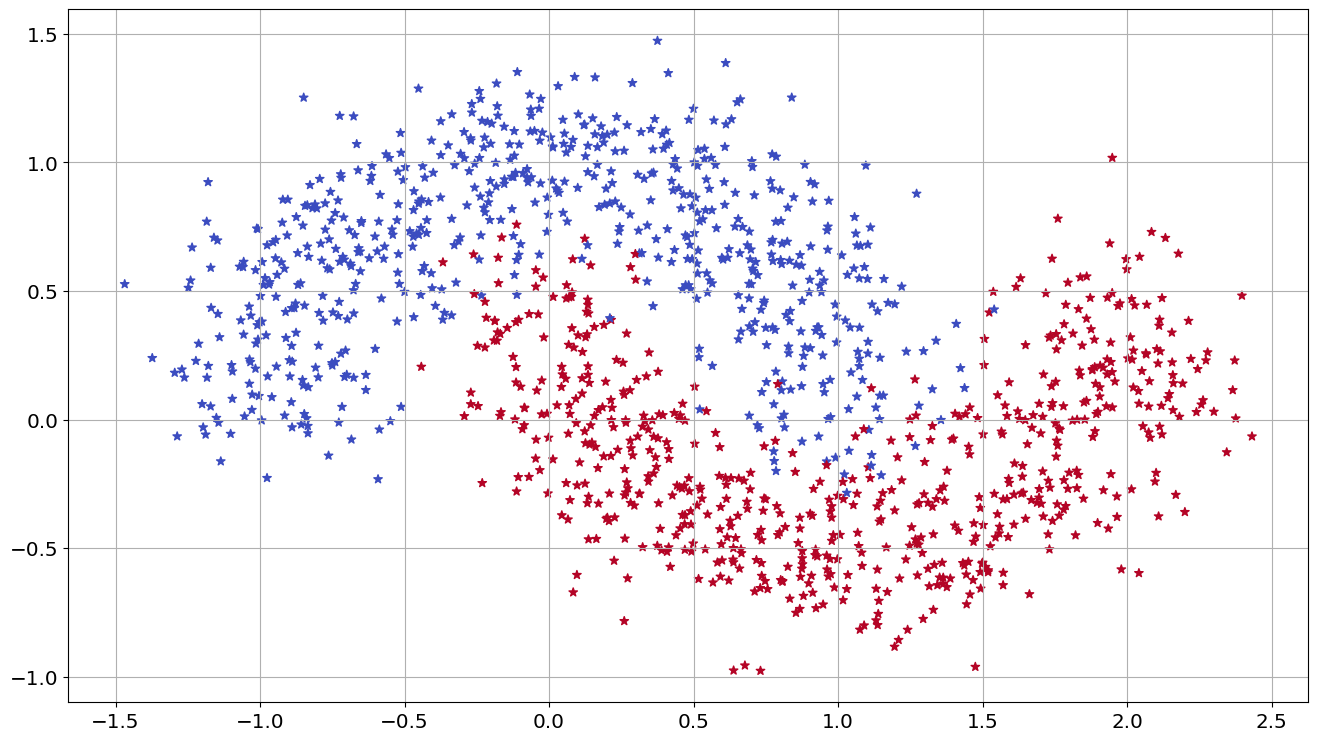

In [7]:
# Lets Plot the data
plt.scatter(X[:,0], X[:,1], s=40, c=y, marker='*', cmap=CMAP)

plt.grid()

In [8]:
y = pd.get_dummies(y).to_numpy()
y

array([[False,  True],
       [ True, False],
       [False,  True],
       ...,
       [ True, False],
       [False,  True],
       [ True, False]])

In [9]:
#  Split the data in training and test sets to measure performance of the model.
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=TEST_SIZE,
                                                    random_state=RANDOM_STATE )

print (X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1024, 2) (1024, 2) (256, 2) (256, 2)


In [10]:
# if you really want to save on space, convert to float32

X_train = X_train.astype(np.float32)

X_test = X_test.astype(np.float32)

y_train = y_train.astype(np.float32)

y_test = y_test.astype(np.float32)

In [11]:
def fn_softmax(z : np.ndarray) -> np.ndarray:
    '''
        Args:
           z : array, Aggregated values 
       Return:
           probs. of each class
    '''
    
    exp_sc = np.exp(z)
    
    return exp_sc / np.sum( exp_sc, axis = 1, keepdims= True)    

In [12]:
sm = fn_softmax(np.asarray([[8, 5, 0], [-10, 0., 10]]))

print (sm, '\n\nTotal of all values', sm.sum(axis = 1))

[[9.52269826e-01 4.74107229e-02 3.19450938e-04]
 [2.06106005e-09 4.53978686e-05 9.99954600e-01]] 

Total of all values [1. 1.]


### Tanh Activation Function

In [13]:
def fn_tanh(z: np.ndarray) -> np.ndarray:
    
    '''
        Args:
           z : array, Aggregated values 
       Return:
           Activations for each z
    '''

    return np.tanh(z)

def fn_tanh_prime(a: np.ndarray) -> np.ndarray:
    '''
        Args:
           a : array, Aggregated values 
       Return:
           Derivative, for each a
    '''

    return 1.0 - np.tanh(a)**2

In [14]:
th = fn_tanh(np.asarray([[-1, 0., 1.], [-np.inf, 0., np.inf]]))
print (th)

[[-0.76159416  0.          0.76159416]
 [-1.          0.          1.        ]]


### Is ourActivation Function working?

In [15]:
np.tanh(0.5)

0.46211715726000974

In [16]:
(1 - np.power(np.tanh(0.5), 2))

0.7864477329659274

In [17]:
fn_tanh_prime(0.5)

0.7864477329659274

## Predict Function

For predictions, we will simply be using the forward propagation. No need to iterate or calculate the back propagation for supervised learning.


In [18]:
# Helper function to predict an output (0 or 1)

def predict(model : dict, X: np.ndarray) -> Literal:
    '''
     Args:
         model
         X: input features
    Returns:
        Predictions against the instances
         
    '''
    W1, b1, W2, b2 = model['W1'],model['b1'],model['W2'],model['b2']
    
    #### Forward Propogation   
    # Layer 1
    z1 = X.dot(W1) + b1 # Agg
    a1 = fn_tanh (z1) # Activation

    # Layer 2
    z2 = a1.dot(W2) + b2
    a2 = fn_softmax(z2)
    
    #return a2>=0.5 # Is it greater than 0.5?
    return np.argmax(a2, axis =1)

In [19]:
# function to evaluate the total loss on the dataset

def calculate_loss(model : dict, X: np.ndarray, y: np.ndarray) -> np.float64:
    '''
    Args:
        model: dictionay object containing weights and biases
        X: Feature Matrix
        y: Labels array
    Returns:
        Average loss
    '''
    W1, b1, W2, b2 = model['W1'],model['b1'],model['W2'],model['b2']
    
    #### Forward Propogation   
    # Layer 1
    z1 = X.dot(W1) + b1 # Agg
    a1 = fn_tanh (z1) # Activation

    # Layer 2
    z2 = a1.dot(W2) + b2
    a2 = fn_softmax(z2)
    
    data_loss = -(y* np.log(a2) + (1-y) * np.log(1-a2)).sum()

    return 1./num_examples * data_loss

## Model

In [20]:
# prepare the Model

def build_model(nn_hdim : np.int64, 
                X : np.ndarray, 
                y : np.ndarray, 
                epochs: np.int64 = EPOCHS, 
                alpha: np.float64 = ALPHA) -> dict:
    
    '''
    Args:
        nn_hdim : Number of nodes in the hidden layer
        X : np.ndarray; Training features to train
        y : np.ndarray; Trainig targets (labels)
        epochs : Number of passes through the training data for gradient descent
        alpha : learning rate
        
    Returns:
        Model: Dictionary object containing weights and biases
    '''
    
    # Initialize the parameters to random values. We need to learn these.
    # Weights
    
    '''
    ##### 
            Change from Rand to Randn gives different shape fo the loss curve
            Demonstrate in the class
    #####
    '''
    
    W1 = np.random.rand(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    W2 = np.random.rand(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    
    b1 = np.zeros ((1, nn_hdim))
    b2 = np.zeros ((1, nn_output_dim))
    
    curr_loss = 0
    
    loss = []
    epoch = []
    #################
    # For Animation #
    #################
    interval = 5 # interval to create animation images
    plot_epoch = np.linspace(0, epochs-1, interval+1) # x axis for plotting loss
    plot_loss_df = pd.DataFrame(plot_epoch, columns= ['epochs'])
    plot_loss_df['loss'] = None
    plot_idx = 0
    
    for i in range (0, epochs):
        
        #### Forward Propogation
        
        # Layer 1
        z1 = X.dot(W1) + b1 # Agg
        a1 = fn_tanh (z1) # Activation
        
        # Layer 2
        z2 = a1.dot(W2) + b2
        a2 = fn_softmax(z2)
        
        ### Back Propogation
        
        dz2 = a2 - y
        
        dW2 = (a1.T).dot(dz2)
        assert (W2.shape == dW2.shape), 'Shape of W2 {} and shape of dW2 {}'.format(W2.shape, dW2.shape)
        db2 = np.sum(dz2, axis = 0, keepdims=True)
        
        dz1 = dz2.dot(W2.T) * fn_tanh_prime(z1)
        
        dW1 = (X.T).dot(dz1)
        assert (W1.shape == dW1.shape), 'Shape of W1 {} and shape of dW1 {}'.format(W1.shape, dW1.shape)
        db1 = np.sum(dz1, axis = 0, keepdims=True)
        
        ########################
        ### Gradient Updates ###
        ########################
        # gradients are being updated for every epoch
        W1 += -alpha *dW1 / num_examples
        W2 += -alpha *dW2 / num_examples
        b1 += -alpha *db1 / num_examples
        b2 += -alpha *db2 / num_examples
        
        # Store model in a dict object
        model = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
        
        # for every nth epoch calculate loss for future plotting
        if i%interval ==  0:
            curr_loss = calculate_loss (model, X, y)
            loss.append(curr_loss)
            epoch.append(i)
            plot_loss_df= pd.DataFrame({'epochs': epoch, 'loss': loss})
            #display(plot_loss_df)
            fn_save_decision_boundary(lambda x: predict(model, x), 
                                      X, y,
                                      plot_idx,
                                      plot_loss_df) # save decision boundary for animation
            plot_idx +=1
            #if plot_idx> 5:
            #    break
                
        # print loss every nth epoch    
        if i%1000 == 0:
            print(f'loss after {i} epochs : {curr_loss}') 
    # update loss_hist
    loss_hist['epoch'] =epoch
    loss_hist['loss'] = loss
    
    
    return model

In [21]:
num_examples, nn_input_dim = X_train.shape # training set size (rows and cols)
nn_output_dim = y_train.shape[1] # output layer dimensionality

# lists to facilitate plotting 
loss_hist = {}

artists = []

In [22]:
###-----------------------------------
### Function to save Decision boundary
###-----------------------------------

def fn_save_decision_boundary(pred_func: Callable[[], np.float64], 
                              X: np.ndarray, y: np.ndarray,
                              idx: np.int32,
                              loss_df : pd.DataFrame):
    '''
        Attrib:
           pred_func : function based on predict method of the classifier
           X : feature matrix
           y : targets
           loss_df : pd.DataFrame, dataframe containing loss
       Return:
           None
    '''
    # Create a figure and axis
    fig, ax = plt.subplots(figsize = (16, 9))
    #display(loss_df)
    # Set min and max values and give it some padding
    xMin, xMax = X[:, 0].min() - .05, X[:, 0].max() + .05
    yMin, yMax = X[:, 1].min() - .05, X[:, 1].max() + .05
    
    # grid size for mesh grid
    h = 0.01
    
    # Generate a grid of points with distance 'h' between them
    xx, yy = np.meshgrid(np.arange(xMin, xMax, h), np.arange(yMin, yMax, h))
    
    # Predict the function value for the whole grid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    
    # Make its shape same as that of xx 
    Z = Z.reshape(xx.shape)
    
    # Now we have Z value corresponding to each of the combination of xx and yy
    # Plot the contour and training examples
    ax.contourf(xx, yy, Z, cmap=CMAP, alpha = 0.7) 
    
    # plot the points as well
    ax.scatter(X[:, 0], X[:, 1], c=np.argmax(y, axis =1), s = 10, cmap=CMAP, ) # edgecolors='black'
    
    # Create inset of width 30% and height 40% of the parent axes' bounding box
    # at the lower left corner (loc=3)
    ax_ins = inset_axes(ax, width="30%", height="40%") # , loc=3


    ax_ins.set_xlim(0, EPOCHS)
    ax_ins.set_ylim(0, loss_df.loc[0, 'loss'])
    loss_df.plot(x='epochs', y = 'loss', ax = ax_ins, lw=2)
    ax_ins.scatter(loss_df.iloc[-1] ['epochs'], loss_df.iloc[-1] ['loss'], c = 'g', marker='>')
    ax_ins.grid()
    
    plt.savefig(os.path.join(outDir, 'decision_boundary', f'img_{idx:003d}.png'), bbox_inches='tight')
    
    #plt.show()
    fig.clear()
    plt.close(fig)

In [ ]:
# Build a model with a 4-dimensional hidden layer
model = build_model(4, X_train, y_train,
                    epochs = EPOCHS, 
                    alpha = ALPHA)

loss after 0 epochs : 1.3599558104148142
loss after 1000 epochs : 0.5717335682732457
loss after 2000 epochs : 0.34649822978086603
loss after 3000 epochs : 0.20048413626837083
loss after 4000 epochs : 0.1642249029676477
loss after 5000 epochs : 0.15430230523953786
loss after 6000 epochs : 0.15069494869939135
loss after 7000 epochs : 0.14907377636248273
loss after 8000 epochs : 0.1482056159057964


In [ ]:
# list of images
imgList = glob.glob(os.path.join(outDir, 'decision_boundary', '*.png'))

# sort in ascending order
imgList.sort() 

frames = [] # for storing the generated images                 
fig = plt.figure(figsize = (16, 9))


for imgName in tqdm(imgList, desc ='Reading Images'):
    
    img = plt.imread(imgName)

    frames.append([plt.imshow(img, animated=True)])

    ani = animation.ArtistAnimation(fig, frames, interval=100, blit=True,
                                repeat_delay=1000)

del frames

ani.save(os.path.join(outDir, 'decision_boundary','one_hidden_layer.mp4'))
plt.close()

'''for file in imgList:
    if os.path.isfile(file):
        os.remove(file)
    else:
        # If it fails, inform the user.
        print(f"Error: {file} file not found" )'''

Reading Images:  50%|█████████████████████▌                     | 1002/2001 [01:39<08:15,  2.02it/s]

In [ ]:
del ani

In [ ]:
import gc
gc.collect()